In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split

pd.set_option('max_colwidth', 80)

In [8]:
df = pd.read_csv('final_data.csv') 
df.head()

,TARGET_FID,Length,Install_year,Arterial_class,Surface_width,Speed_limit,Slope,Width,Break_Yr,Target,...,Surface_type_,Surface_type_AC,Surface_type_AC/AC,Surface_type_AC/PCC,Surface_type_GRAVEL,Surface_type_PCC,Surface_type_ST,AGE,Nearby_breaks_1yr,Process_year
0,1,314.79,1972,2.0,40.0,25.0,0.0,8.0,NaN,0,...,0,0,0,0,0,1,0,38,0,2010
1,2,363.39,1972,0.0,46.0,20.0,4.0,8.0,NaN,0,...,0,1,0,0,0,0,0,38,0,2010
2,3,323.51,1972,0.0,46.0,20.0,4.0,8.0,NaN,0,...,0,1,0,0,0,0,0,38,0,2010
3,4,329.13,1928,0.0,0.0,20.0,6.0,12.0,NaN,0,...,0,0,0,0,0,0,1,82,0,2010
4,5,273.64,1928,2.0,42.0,25.0,4.0,18.0,NaN,0,...,0,0,0,1,0,0,0,82,0,2010


In [5]:
df['Target'].unique()

array([0, 1])

In [6]:
df_2014 = df[df['Process_year'] == 2014]
df_2014.shape

(68274, 56)

In [7]:
df_2014['Break_Yr'].unique()

array([  nan, 2014.])

In [8]:
columns = df_2014.columns.drop(['TARGET_FID', 'Process_year', 'Break_Yr'])
df_2014_cols = df_2014[columns]
print(df_2014_cols.shape)
#df_2014_cols_cleaned = df_2014_cols[~df_2014_cols.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float32) # removes rows with nan or inf points
df_2014_cols_cleaned = df_2014_cols.dropna(axis=0).astype(np.float32) # removes rows with nan or inf points
print(df_2014_cols_cleaned.shape)


(68274, 53)
(58917, 53)


In [9]:
features_df = df_2014_cols_cleaned.drop('Target', axis=1)
target_df = df_2014_cols_cleaned[['Target']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)

In [11]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [12]:
preds = etc.predict(X_test)
probs = etc.predict_proba(X_test)
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.7450282516528574
0.4909090909090909
0.7297297297297297


In [13]:
confusion_matrix(y_test, preds)

array([[11719,    10],
       [   28,    27]])

array([ 6,  0,  1, 50,  5,  3, 51,  2,  4, 21, 28, 48, 29, 44, 30, 40, 12,
       46, 49, 24, 32, 33, 41, 45, 23, 15, 16, 43, 11,  9, 10, 19, 17, 47,
       39, 35, 31, 34, 13, 37,  7, 26, 22, 36, 14, 25, 20, 18, 38,  8, 42,
       27])

In [14]:
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    feature_name = features[indices[f]]
    print(feature_name)
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print()

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Feature ranking:


NameError: name 'features' is not defined

# XGBoost

In [1]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [2]:
dtrain = xgb.DMatrix(X_train, label=y_train)

NameError: name 'X_train' is not defined

In [10]:
# set param
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

# train
# bst = xgb.train(param, dtrain)

In [18]:
dtest = xgb.DMatrix(X_test)
ypred = bst.predict(dtest)
preds = np.where(ypred > 0.5, 1, ypred)
preds = np.where(preds <= 0.5, 0, preds)
preds.min()

0.0

In [19]:
# compare scores
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.7090909090909091
0.41818181818181815
1.0


In [20]:
confusion_matrix(y_test, preds)

array([[11729,     0],
       [   32,    23]])

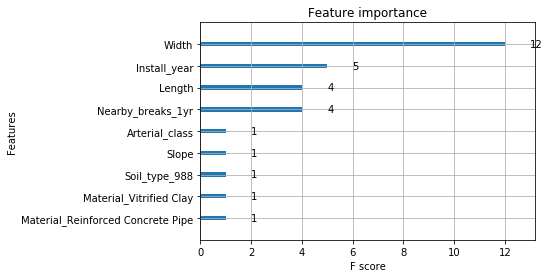

In [21]:
xgb.plot_importance(bst)

## Cross Val 

In [4]:
from crossval import crossval_by_year

In [29]:
# crossval_by_year(data, classifier_fn, params_dict, n_val=2, print_results=True)
crossval_by_year(df, xgb, param, n_val=2, print_results=True)

TypeError: 'module' object is not callable

* skip creating dtrain
* don't change anything with how you set up the param settings
* call the crossval function with crossval_by_year(df, xgb.XGBClassifier, param)
* hopefully that's all??

In [11]:
crossval_by_year(df, xgb.XGBClassifier, param)

Cross-validation iteration 1 of 11 results:
Balanced accuracy = 0.6165
Recall            = 0.3147
Precision         = 0.9184

Cross-validation iteration 2 of 11 results:
Balanced accuracy = 0.5668
Recall            = 0.2015
Precision         = 0.9322

Cross-validation iteration 3 of 11 results:
Balanced accuracy = 0.5677
Recall            = 0.1818
Precision         = 0.9535

Cross-validation iteration 4 of 11 results:
Balanced accuracy = 0.6164
Recall            = 0.2490
Precision         = 0.9839

Cross-validation iteration 5 of 11 results:
Balanced accuracy = 0.6119
Recall            = 0.2401
Precision         = 0.9837

Cross-validation iteration 6 of 11 results:
Balanced accuracy = 0.5896
Recall            = 0.2123
Precision         = 0.9669

Cross-validation iteration 7 of 11 results:
Balanced accuracy = 0.5751
Recall            = 0.1876
Precision         = 0.9626

Cross-validation iteration 8 of 11 results:
Balanced accuracy = 0.6014
Recall            = 0.2215
Precision         = 

array([0.59159195, 0.22426524, 0.95891866])